# Notebook 3: Data preprocessing and splitting

**Objective**: 
- split the data into training, validation, and test sets
- preprocess the data (e.g., normalization, handling missing values)

___

## Table of Contents

1. [Setup and Configuration](#1-setup-and-configuration)
2. [Load Engineered Features](#2-load-engineered-features)
3. [Prepare Feature and Target Columns](#3-prepare-feature-and-target-columns)
4. [Time-Series Data Splitting](#4-time-series-data-splitting)
5. [Feature Scaling](#5-feature-scaling)
6. [Sequence Creation for Deep Learning](#6-sequence-creation-for-deep-learning)
7. [Class Imbalance Analysis](#7-class-imbalance-analysis)
8. [Save Sequences to Disk](#8-save-sequences-to-disk)
9. [Data Loading Utility Function](#9-data-loading-utility-function)

___

## 1. Setup and Configuration

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Scaling utilities
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.utils.class_weight import compute_class_weight

# Save/load utilities
import pickle
import os

# Set random seeds
SEED = 42
np.random.seed(SEED)

print("[OK] Libraries imported")

[OK] Libraries imported


In [2]:
# Configure plotting
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 11

print("[OK] Plotting configuration")

[OK] Plotting configuration


In [3]:
# Define paths and constants
PROCESSED_DIR = '../data_new/data_processed/'
SEQUENCES_DIR = '../data_new/sequences/'
SCALERS_DIR = '../data_new/scalers/'
RESULTS_DIR = '../results/'
FIGURES_DIR = '../results/figures/preprocessing/'

# Create directories
for directory in [SEQUENCES_DIR, SCALERS_DIR, FIGURES_DIR]:
    os.makedirs(directory, exist_ok=True)

# Asset information
ASSETS = {
    'AAPL': {'name': 'Apple Inc.', 'type': 'stock'},
    'AMZN': {'name': 'Amazon.com Inc.', 'type': 'stock'},
    'NVDA': {'name': 'NVIDIA Corporation', 'type': 'stock'},
    'SPY': {'name': 'S&P 500 ETF', 'type': 'stock'},
    'BTC-USD': {'name': 'Bitcoin', 'type': 'crypto'}
}

PREDICTION_HORIZONS = {
    'stocks': {
        '1day': 1,
        '1week': 5,    # 5 trading days
        '1month': 20   # 20 trading days    
    },
    'crypto': {
        '1day': 1,
        '1week': 7,    # 7 calendar days
        '1month': 30   # 30 calendar days
    }
}

SEQUENCE_LENGTHS = {
    '1day': 7,       
    '1week': 30, 
    '1month': 90
}

# Target horizons
TARGET_HORIZONS = ['1day', '1week', '1month']

# Split ratios
TRAIN_RATIO = 0.7  
VAL_RATIO = 0.10   
TEST_RATIO = 0.20   

print("[OK] Configuration complete")

[OK] Configuration complete


## 2. Load Engineered Features

Load the feature-engineered datasets from Notebook 02.

In [4]:
# Load all processed datasets (cleaned versions)
data = {}

print("="*80)
print("LOADING PROCESSED DATA")
print("="*80)

for asset in ASSETS.keys():
    filename = f'{PROCESSED_DIR}{asset}_features_cleaned.csv'
    df = pd.read_csv(filename, index_col=0, parse_dates=True)
    data[asset] = df
    
    print(f"\n{asset}:")
    print(f"  Shape: {df.shape}")
    print(f"  Date range: {df.index.min()} to {df.index.max()}")
    print(f"  Columns: {len(df.columns)}")

print("\n" + "="*80)
print("[OK] All data loaded successfully")
print("="*80)

LOADING PROCESSED DATA

AAPL:
  Shape: (6303, 47)
  Date range: 2000-10-16 00:00:00 to 2025-11-06 00:00:00
  Columns: 47

AMZN:
  Shape: (6303, 47)
  Date range: 2000-10-16 00:00:00 to 2025-11-06 00:00:00
  Columns: 47

NVDA:
  Shape: (6303, 47)
  Date range: 2000-10-16 00:00:00 to 2025-11-06 00:00:00
  Columns: 47

NVDA:
  Shape: (6303, 47)
  Date range: 2000-10-16 00:00:00 to 2025-11-06 00:00:00
  Columns: 47

SPY:
  Shape: (6303, 48)
  Date range: 2000-10-16 00:00:00 to 2025-11-06 00:00:00
  Columns: 48

BTC-USD:
  Shape: (3872, 47)
  Date range: 2015-04-04 00:00:00 to 2025-11-08 00:00:00
  Columns: 47

[OK] All data loaded successfully

SPY:
  Shape: (6303, 48)
  Date range: 2000-10-16 00:00:00 to 2025-11-06 00:00:00
  Columns: 48

BTC-USD:
  Shape: (3872, 47)
  Date range: 2015-04-04 00:00:00 to 2025-11-08 00:00:00
  Columns: 47

[OK] All data loaded successfully


## 3. Prepare Feature and Target Columns

Separate features from targets and identify column groups.

In [5]:
def get_feature_target_columns(df):
    """
    Separate feature columns from target columns.
    Exclude raw OHLCV columns as they're already encoded in features.
    """
    # Columns to exclude from features
    exclude_cols = ['open', 'high', 'low', 'close', 'volume']
    
    # Target columns
    target_cols = [col for col in df.columns if col.startswith('target_')]
    
    # Feature columns (everything else, but only numeric)
    feature_cols = [col for col in df.columns 
                   if col not in exclude_cols and col not in target_cols
                   and pd.api.types.is_numeric_dtype(df[col])]
    
    return feature_cols, target_cols

# Test with one asset
sample_asset = 'AAPL'
feature_cols, target_cols = get_feature_target_columns(data[sample_asset])

print(f"Column Analysis for {sample_asset}:")
print("="*60)
print(f"Total columns: {len(data[sample_asset].columns)}")
print(f"Feature columns: {len(feature_cols)}")
print(f"Target columns: {len(target_cols)}")
print(f"\nTarget columns: {target_cols}")

Column Analysis for AAPL:
Total columns: 47
Feature columns: 39
Target columns: 3

Target columns: ['target_1day', 'target_1week', 'target_1month']


## 4. Time-Series Data Splitting

Split data chronologically to prevent look-ahead bias.

In [6]:
def time_series_split(df, train_ratio=TRAIN_RATIO, val_ratio=VAL_RATIO, test_ratio=TEST_RATIO):
    """
    Split time series data chronologically.
    
    Returns:
        train_df, val_df, test_df
    """
    assert abs(train_ratio + val_ratio + test_ratio - 1.0) < 1e-6, "Ratios must sum to 1.0"
    
    n = len(df)
    train_end = int(n * train_ratio)
    val_end = int(n * (train_ratio + val_ratio))
    
    train_df = df.iloc[:train_end]
    val_df = df.iloc[train_end:val_end]
    test_df = df.iloc[val_end:]
    
    return train_df, val_df, test_df

# Split all assets
splits = {}

print("="*80)
print("TIME-SERIES DATA SPLITTING")
print("="*80)

for asset, df in data.items():
    train_df, val_df, test_df = time_series_split(df, TRAIN_RATIO, VAL_RATIO, TEST_RATIO)
    
    splits[asset] = {
        'train': train_df,
        'val': val_df,
        'test': test_df
    }
    
    print(f"\n{asset}:")
    print(f"  Total samples: {len(df)}")
    print(f"  Train: {len(train_df)} ({len(train_df)/len(df)*100:.1f}%) [{train_df.index.min()} to {train_df.index.max()}]")
    print(f"  Val:   {len(val_df)} ({len(val_df)/len(df)*100:.1f}%) [{val_df.index.min()} to {val_df.index.max()}]")
    print(f"  Test:  {len(test_df)} ({len(test_df)/len(df)*100:.1f}%) [{test_df.index.min()} to {test_df.index.max()}]")

print("\n" + "="*80)
print("[OK] Data splitting complete")
print("="*80)

TIME-SERIES DATA SPLITTING

AAPL:
  Total samples: 6303
  Train: 4412 (70.0%) [2000-10-16 00:00:00 to 2018-05-01 00:00:00]
  Val:   630 (10.0%) [2018-05-02 00:00:00 to 2020-10-29 00:00:00]
  Test:  1261 (20.0%) [2020-10-30 00:00:00 to 2025-11-06 00:00:00]

AMZN:
  Total samples: 6303
  Train: 4412 (70.0%) [2000-10-16 00:00:00 to 2018-05-01 00:00:00]
  Val:   630 (10.0%) [2018-05-02 00:00:00 to 2020-10-29 00:00:00]
  Test:  1261 (20.0%) [2020-10-30 00:00:00 to 2025-11-06 00:00:00]

NVDA:
  Total samples: 6303
  Train: 4412 (70.0%) [2000-10-16 00:00:00 to 2018-05-01 00:00:00]
  Val:   630 (10.0%) [2018-05-02 00:00:00 to 2020-10-29 00:00:00]
  Test:  1261 (20.0%) [2020-10-30 00:00:00 to 2025-11-06 00:00:00]

SPY:
  Total samples: 6303
  Train: 4412 (70.0%) [2000-10-16 00:00:00 to 2018-05-01 00:00:00]
  Val:   630 (10.0%) [2018-05-02 00:00:00 to 2020-10-29 00:00:00]
  Test:  1261 (20.0%) [2020-10-30 00:00:00 to 2025-11-06 00:00:00]

BTC-USD:
  Total samples: 3872
  Train: 2710 (70.0%) [201

**Remark**:

we split the data in a chronological order for the train, val and test. Mixing up the different periods could lead to look ahead bias.

## 5. Feature Scaling

Apply normalization to features. We'll use **StandardScaler** as the primary method.

**Important**: Fit scaler on training data only, then transform all sets.

In [7]:
def scale_features(train_df, val_df, test_df, feature_cols, scaler_type='standard'):
    """
    Scale features using specified scaler.
    Fit on training data only.
    
    Args:
        scaler_type: 'standard', 'minmax', or 'robust'
    
    Returns:
        scaled train_df, val_df, test_df, fitted scaler
    """
    # Select scaler
    if scaler_type == 'standard':
        scaler = StandardScaler()
    elif scaler_type == 'minmax':
        scaler = MinMaxScaler()
    elif scaler_type == 'robust':
        scaler = RobustScaler()
    else:
        raise ValueError(f"Unknown scaler type: {scaler_type}")
    
    # Fit on training data
    scaler.fit(train_df[feature_cols])
    
    # Transform all sets
    train_scaled = train_df.copy()
    val_scaled = val_df.copy()
    test_scaled = test_df.copy()
    
    train_scaled[feature_cols] = scaler.transform(train_df[feature_cols])
    val_scaled[feature_cols] = scaler.transform(val_df[feature_cols])
    test_scaled[feature_cols] = scaler.transform(test_df[feature_cols])
    
    return train_scaled, val_scaled, test_scaled, scaler

print("[OK] Scaling function defined")

[OK] Scaling function defined


In [8]:
# Scale all assets
scaled_splits = {}
scalers = {}

print("="*80)
print("FEATURE SCALING (StandardScaler)")
print("="*80)

for asset in ASSETS.keys():
    print(f"\nScaling {asset}...")
    
    feature_cols, target_cols = get_feature_target_columns(data[asset])
    
    train_scaled, val_scaled, test_scaled, scaler = scale_features(
        splits[asset]['train'],
        splits[asset]['val'],
        splits[asset]['test'],
        feature_cols,
        scaler_type='standard'
    )
    
    scaled_splits[asset] = {
        'train': train_scaled,
        'val': val_scaled,
        'test': test_scaled,
        'feature_cols': feature_cols,
        'target_cols': target_cols
    }
    
    scalers[asset] = scaler
    
    # Save scaler
    scaler_filename = f'{SCALERS_DIR}{asset}_scaler.pkl'
    with open(scaler_filename, 'wb') as f:
        pickle.dump(scaler, f)
    
    print(f"[OK] Scaled {len(feature_cols)} features")
    print(f"[OK] Scaler saved to {scaler_filename}")

print("\n" + "="*80)
print("[OK] Feature scaling complete for all assets")
print("="*80)

FEATURE SCALING (StandardScaler)

Scaling AAPL...
[OK] Scaled 39 features
[OK] Scaler saved to ../data_new/scalers/AAPL_scaler.pkl

Scaling AMZN...
[OK] Scaled 39 features
[OK] Scaler saved to ../data_new/scalers/AMZN_scaler.pkl

Scaling NVDA...
[OK] Scaled 39 features
[OK] Scaler saved to ../data_new/scalers/NVDA_scaler.pkl

Scaling SPY...
[OK] Scaled 40 features
[OK] Scaler saved to ../data_new/scalers/SPY_scaler.pkl

Scaling BTC-USD...
[OK] Scaled 39 features
[OK] Scaler saved to ../data_new/scalers/BTC-USD_scaler.pkl

[OK] Feature scaling complete for all assets
[OK] Scaled 40 features
[OK] Scaler saved to ../data_new/scalers/SPY_scaler.pkl

Scaling BTC-USD...
[OK] Scaled 39 features
[OK] Scaler saved to ../data_new/scalers/BTC-USD_scaler.pkl

[OK] Feature scaling complete for all assets


**Remark**:

This implementation of scaling avoids lookahead bias. The validation and testing data are scaled using the mean and the deviation obtained from the training data.

## 6. Sequence Creation for Deep Learning

Create 3D arrays (n_samples, sequence_length, n_features) for RNN/LSTM/GRU models.

In [9]:
def create_sequences(df, feature_cols, target_col, sequence_length):
    """
    Create sequences for time series prediction.
    Memory-efficient version using pre-allocated arrays.
    
    Args:
        df: DataFrame with features and targets
        feature_cols: List of feature column names
        target_col: Target column name
        sequence_length: Number of days to look back
    
    Returns:
        X: 3D array (n_samples, sequence_length, n_features)
        y: 1D array (n_samples,)
    """
    # Extract feature and target arrays
    features = df[feature_cols].values
    targets = df[target_col].values
    
    # Pre-allocate arrays for memory efficiency
    n_samples = len(df) - sequence_length
    n_features = len(feature_cols)
    
    X = np.zeros((n_samples, sequence_length, n_features), dtype=np.float32)
    y = np.zeros(n_samples, dtype=np.float32)
    
    # Fill sequences using vectorized operations where possible
    for i in range(n_samples):
        X[i] = features[i:i+sequence_length]
        y[i] = targets[i+sequence_length]
    
    return X, y

print("[OK] Sequence creation function defined")

[OK] Sequence creation function defined


In [10]:
# Create sequences for all assets and horizons
sequences = {}

print("="*80)
print("SEQUENCE CREATION")
print("="*80)
print(f"Using sequence lengths: {SEQUENCE_LENGTHS}")
print("(Prediction horizons defined in target variable creation)")

for asset in ASSETS.keys():
    print(f"\n{asset} ({ASSETS[asset]['type']}):")
    sequences[asset] = {}
    
    feature_cols = scaled_splits[asset]['feature_cols']
    target_cols = scaled_splits[asset]['target_cols']
    
    # Get appropriate horizons for this asset type
    asset_type = 'crypto' if asset == 'BTC-USD' else 'stocks'
    horizons = PREDICTION_HORIZONS[asset_type]
    
    for target_col in target_cols:
        # Extract horizon name (e.g., 'target_1day' -> '1day')
        horizon = target_col.replace('target_', '')
        
        if horizon not in horizons:
            continue
        
        horizon_days = horizons[horizon]
        sequence_length = SEQUENCE_LENGTHS[horizon]
        
        print(f"  {horizon}: predicting {horizon_days} day(s) ahead, using {sequence_length} days context...")
        
        # Create sequences for train/val/test
        X_train, y_train = create_sequences(
            scaled_splits[asset]['train'],
            feature_cols,
            target_col,
            sequence_length
        )
        
        X_val, y_val = create_sequences(
            scaled_splits[asset]['val'],
            feature_cols,
            target_col,
            sequence_length
        )
        
        X_test, y_test = create_sequences(
            scaled_splits[asset]['test'],
            feature_cols,
            target_col,
            sequence_length
        )
        
        # Calculate memory usage
        memory_mb = (X_train.nbytes + X_val.nbytes + X_test.nbytes) / (1024**2)
        
        sequences[asset][horizon] = {
            'X_train': X_train,
            'y_train': y_train,
            'X_val': X_val,
            'y_val': y_val,
            'X_test': X_test,
            'y_test': y_test,
            'sequence_length': sequence_length,
            'prediction_horizon': horizon_days,
            'n_features': len(feature_cols)
        }
        
        print(f"    Train: X={X_train.shape}, y={y_train.shape}")
        print(f"    Val:   X={X_val.shape}, y={y_val.shape}")
        print(f"    Test:  X={X_test.shape}, y={y_test.shape}")
        print(f"    Memory: {memory_mb:.1f} MB")
        print(f"    Predicting: {horizon_days} day(s) ahead using {sequence_length} days history")

print("\n" + "="*80)
print("[OK] Sequence creation complete for all assets and horizons")
print("="*80)

SEQUENCE CREATION
Using sequence lengths: {'1day': 7, '1week': 30, '1month': 90}
(Prediction horizons defined in target variable creation)

AAPL (stock):
  1day: predicting 1 day(s) ahead, using 7 days context...
    Train: X=(4405, 7, 39), y=(4405,)
    Val:   X=(623, 7, 39), y=(623,)
    Test:  X=(1254, 7, 39), y=(1254,)
    Memory: 6.5 MB
    Predicting: 1 day(s) ahead using 7 days history
  1week: predicting 5 day(s) ahead, using 30 days context...
    Train: X=(4382, 30, 39), y=(4382,)
    Val:   X=(600, 30, 39), y=(600,)
    Test:  X=(1231, 30, 39), y=(1231,)
    Memory: 27.7 MB
    Predicting: 5 day(s) ahead using 30 days history
  1month: predicting 20 day(s) ahead, using 90 days context...
    Train: X=(4322, 90, 39), y=(4322,)
    Val:   X=(540, 90, 39), y=(540,)
    Test:  X=(1171, 90, 39), y=(1171,)
    Memory: 80.8 MB
    Predicting: 20 day(s) ahead using 90 days history

AMZN (stock):
  1day: predicting 1 day(s) ahead, using 7 days context...
    Train: X=(4322, 90, 39), 

**Remarks**:

Since we didnt have enough time, we decided to orient our project to the study of different models instead of optimizing the lookback window for the data. So for 1 day we chose a window of 7 days, for 1 week we chose 1 month and for 1 month we take 90.

## 7. Class Imbalance Analysis

Analyze class distribution and compute class weights.

In [11]:
# Compute class weights for all assets and horizons
class_weights_dict = {}

print("="*80)
print("CLASS IMBALANCE ANALYSIS & WEIGHTS COMPUTATION")
print("="*80)

for asset in ASSETS.keys():
    print(f"\n{asset}:")
    class_weights_dict[asset] = {}
    
    for horizon in sequences[asset].keys():
        y_train = sequences[asset][horizon]['y_train']
        
        # Count classes
        unique, counts = np.unique(y_train, return_counts=True)
        class_dist = dict(zip(unique, counts))
        
        # Compute class weights
        classes = np.array([0, 1])
        weights = compute_class_weight(
            class_weight='balanced',
            classes=classes,
            y=y_train
        )
        class_weights = dict(zip(classes, weights))
        
        class_weights_dict[asset][horizon] = class_weights
        
        # Calculate imbalance ratio
        n_down = class_dist.get(0, 0)
        n_up = class_dist.get(1, 0)
        total = n_down + n_up
        imbalance_ratio = max(n_down, n_up) / min(n_down, n_up) if min(n_down, n_up) > 0 else 0
        
        print(f"  {horizon:10s}: DOWN={n_down:5d} ({n_down/total*100:5.1f}%), UP={n_up:5d} ({n_up/total*100:5.1f}%)")
        print(f"              Imbalance ratio: {imbalance_ratio:.2f}:1")
        print(f"              Class weights: {{0: {class_weights[0]:.3f}, 1: {class_weights[1]:.3f}}}")

print("\n" + "="*80)
print("[OK] Class weights computed for all assets and horizons")
print("="*80)

CLASS IMBALANCE ANALYSIS & WEIGHTS COMPUTATION

AAPL:
  1day      : DOWN= 2121 ( 48.1%), UP= 2284 ( 51.9%)
              Imbalance ratio: 1.08:1
              Class weights: {0: 1.038, 1: 0.964}
  1week     : DOWN= 1887 ( 43.1%), UP= 2495 ( 56.9%)
              Imbalance ratio: 1.32:1
              Class weights: {0: 1.161, 1: 0.878}
  1month    : DOWN= 1660 ( 38.4%), UP= 2662 ( 61.6%)
              Imbalance ratio: 1.60:1
              Class weights: {0: 1.302, 1: 0.812}

AMZN:
  1day      : DOWN= 2163 ( 49.1%), UP= 2242 ( 50.9%)
              Imbalance ratio: 1.04:1
              Class weights: {0: 1.018, 1: 0.982}
  1week     : DOWN= 1997 ( 45.6%), UP= 2385 ( 54.4%)
              Imbalance ratio: 1.19:1
              Class weights: {0: 1.097, 1: 0.919}
  1month    : DOWN= 1695 ( 39.2%), UP= 2627 ( 60.8%)
              Imbalance ratio: 1.55:1
              Class weights: {0: 1.275, 1: 0.823}

NVDA:
  1day      : DOWN= 2161 ( 49.1%), UP= 2244 ( 50.9%)
              Imbalance ratio: 1.

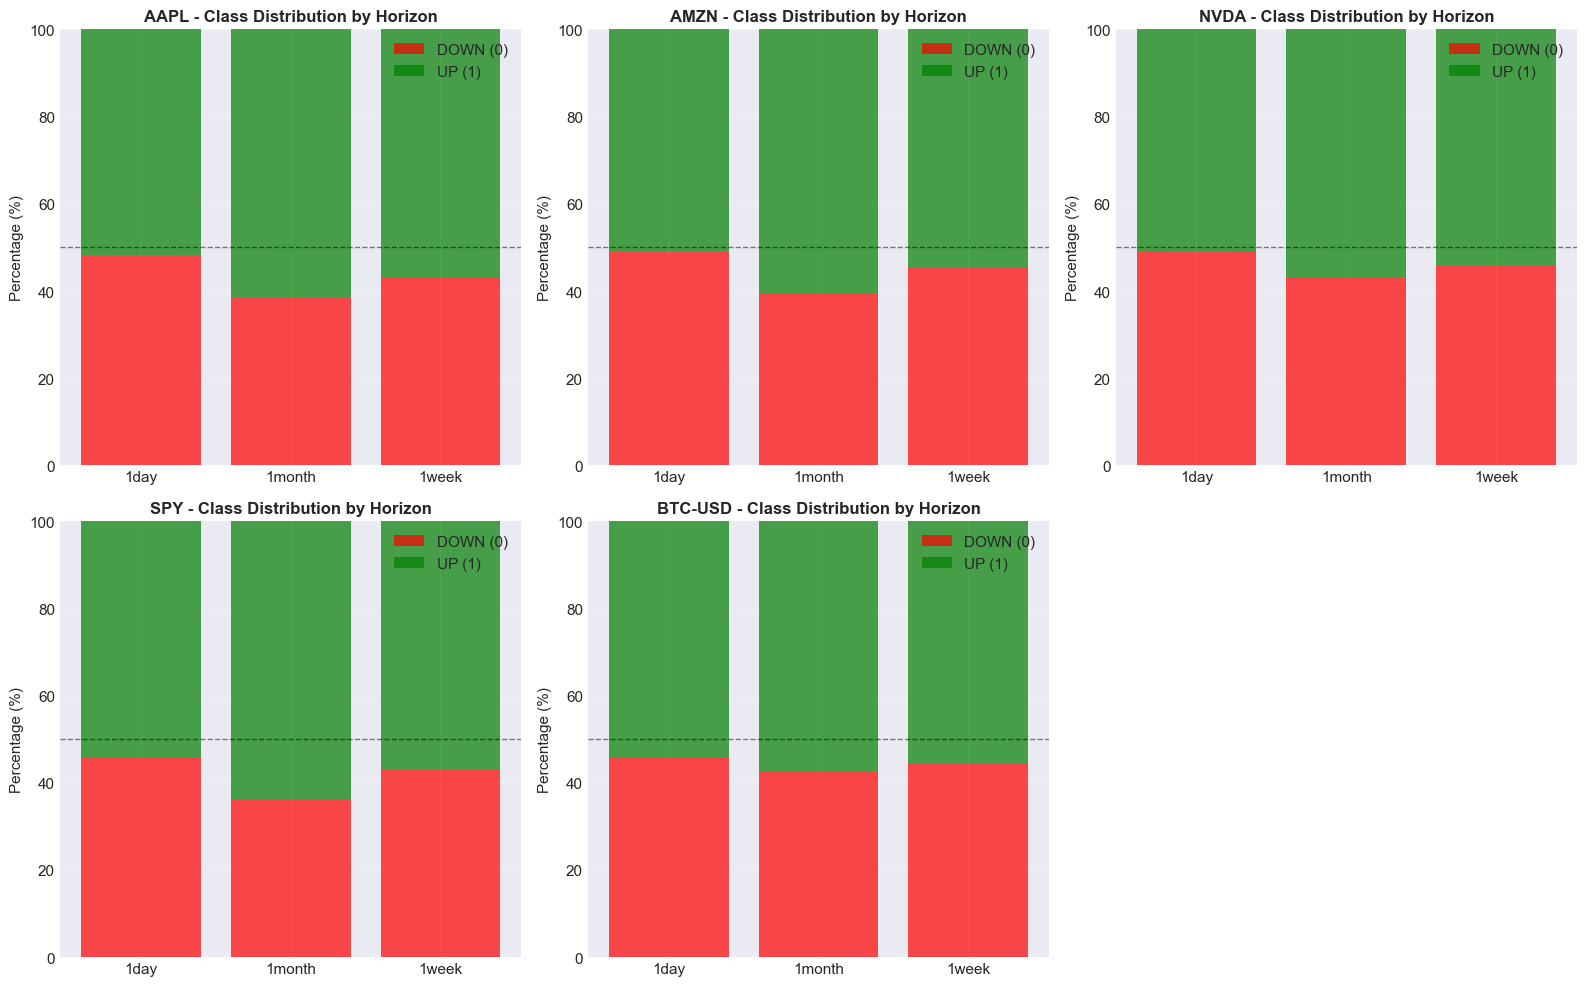

[OK] Class distribution visualization saved


In [12]:
# Visualize class distributions
n_assets = len(ASSETS)
n_cols = 3
n_rows = (n_assets + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 5 * n_rows))
if n_rows == 1:
    axes = axes.reshape(1, -1)
axes = axes.flatten()

for idx, asset in enumerate(ASSETS.keys()):
    ax = axes[idx]
    
    # Collect data for all horizons
    horizons_list = []
    down_pcts = []
    up_pcts = []
    
    for horizon in sorted(sequences[asset].keys()):
        y_train = sequences[asset][horizon]['y_train']
        unique, counts = np.unique(y_train, return_counts=True)
        class_dist = dict(zip(unique, counts))
        
        n_down = class_dist.get(0, 0)
        n_up = class_dist.get(1, 0)
        total = n_down + n_up
        
        horizons_list.append(horizon)
        down_pcts.append(n_down / total * 100)
        up_pcts.append(n_up / total * 100)
    
    # Create stacked bar chart
    x = np.arange(len(horizons_list))
    ax.bar(x, down_pcts, label='DOWN (0)', color='red', alpha=0.7)
    ax.bar(x, up_pcts, bottom=down_pcts, label='UP (1)', color='green', alpha=0.7)
    
    ax.set_xticks(x)
    ax.set_xticklabels(horizons_list)
    ax.set_ylabel('Percentage (%)')
    ax.set_title(f'{asset} - Class Distribution by Horizon', fontsize=12, fontweight='bold')
    ax.legend()
    ax.axhline(y=50, color='black', linestyle='--', linewidth=1, alpha=0.5)
    ax.grid(True, alpha=0.3, axis='y')
    ax.set_ylim([0, 100])

# Hide extra subplots if any
for idx in range(len(ASSETS), len(axes)):
    axes[idx].set_visible(False)

plt.tight_layout()
plt.savefig(f'{FIGURES_DIR}class_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("[OK] Class distribution visualization saved")

**Remark on Class Distribution:**

Our training data shows relatively balanced classes across all assets and horizons. The imbalance ratios range from 1.04:1 to 1.60:1, which is quite good for financial data. For example, AAPL's 1-day prediction has nearly equal UP/DOWN distribution (51.9% vs 48.1%). However, longer horizons show more imbalance - the 1-month predictions tend to favor UP movements (around 60%), which makes sense since markets generally trend upward over longer periods. We computed balanced class weights to handle this during training.

**Remark for Deep Learning Models:**

The computed class weights will be important for our neural networks. We'll pass these weights to the loss function during training so the model doesn't just learn to predict the majority class. For instance, when training on AAPL's 1-month horizon, the model will penalize misclassifying DOWN movements more heavily (weight: 1.302) than UP movements (weight: 0.812). This helps the model learn both patterns equally well, even though DOWN movements are less frequent in the training data. Without these weights, our models might just predict UP most of the time and still get decent accuracy, but would fail in real life cases.

## 8. Save Sequences to Disk

Save processed sequences for model training.

In [13]:
print("="*80)
print("SAVING SEQUENCES TO DISK")
print("="*80)

for asset in ASSETS.keys():
    print(f"\n{asset}:")
    
    for horizon in sequences[asset].keys():
        # Create filename
        filename = f'{SEQUENCES_DIR}{asset}_{horizon}_sequences.npz'
        
        # Save using numpy compressed format
        np.savez_compressed(
            filename,
            X_train=sequences[asset][horizon]['X_train'],
            y_train=sequences[asset][horizon]['y_train'],
            X_val=sequences[asset][horizon]['X_val'],
            y_val=sequences[asset][horizon]['y_val'],
            X_test=sequences[asset][horizon]['X_test'],
            y_test=sequences[asset][horizon]['y_test'],
            sequence_length=sequences[asset][horizon]['sequence_length'],
            n_features=sequences[asset][horizon]['n_features']
        )
        
        # Get file size
        file_size = os.path.getsize(filename) / (1024**2)  # MB
        print(f"  {horizon:10s}: {filename} ({file_size:.2f} MB)")

print("\n" + "="*80)
print("[OK] All sequences saved successfully")
print("="*80)

SAVING SEQUENCES TO DISK

AAPL:
  1day      : ../data_new/sequences/AAPL_1day_sequences.npz (0.77 MB)
  1week     : ../data_new/sequences/AAPL_1week_sequences.npz (0.95 MB)
  1week     : ../data_new/sequences/AAPL_1week_sequences.npz (0.95 MB)
  1month    : ../data_new/sequences/AAPL_1month_sequences.npz (1.35 MB)

AMZN:
  1day      : ../data_new/sequences/AMZN_1day_sequences.npz (0.77 MB)
  1month    : ../data_new/sequences/AAPL_1month_sequences.npz (1.35 MB)

AMZN:
  1day      : ../data_new/sequences/AMZN_1day_sequences.npz (0.77 MB)
  1week     : ../data_new/sequences/AMZN_1week_sequences.npz (0.97 MB)
  1week     : ../data_new/sequences/AMZN_1week_sequences.npz (0.97 MB)
  1month    : ../data_new/sequences/AMZN_1month_sequences.npz (1.45 MB)

NVDA:
  1day      : ../data_new/sequences/NVDA_1day_sequences.npz (0.77 MB)
  1month    : ../data_new/sequences/AMZN_1month_sequences.npz (1.45 MB)

NVDA:
  1day      : ../data_new/sequences/NVDA_1day_sequences.npz (0.77 MB)
  1week     : ../d

In [14]:
# Save class weights
class_weights_filename = f'{SEQUENCES_DIR}class_weights.pkl'
with open(class_weights_filename, 'wb') as f:
    pickle.dump(class_weights_dict, f)

print(f"[OK] Class weights saved to {class_weights_filename}")

[OK] Class weights saved to ../data_new/sequences/class_weights.pkl


## 9. Data Loading Utility Function

Create a utility function to easily load sequences for model training.

In [15]:
def load_sequences(asset, horizon, sequences_dir='../data_new/sequences/'):
    """
    Load preprocessed sequences from disk.
    
    Args:
        asset: Asset name (e.g., 'AAPL', 'BTC-USD')
        horizon: Prediction horizon (e.g., '1day', '1week', '1month')
        sequences_dir: Directory containing sequence files
    
    Returns:
        Dictionary with X_train, y_train, X_val, y_val, X_test, y_test, metadata
    """
    filename = f'{sequences_dir}{asset}_{horizon}_sequences.npz'
    
    data = np.load(filename)
    
    return {
        'X_train': data['X_train'],
        'y_train': data['y_train'],
        'X_val': data['X_val'],
        'y_val': data['y_val'],
        'X_test': data['X_test'],
        'y_test': data['y_test'],
        'sequence_length': int(data['sequence_length']),
        'n_features': int(data['n_features'])
    }

def load_class_weights(sequences_dir='../data_new/sequences/'):
    """
    Load class weights from disk.
    
    Returns:
        Dictionary: {asset: {horizon: {0: weight_0, 1: weight_1}}}
    """
    filename = f'{sequences_dir}class_weights.pkl'
    with open(filename, 'rb') as f:
        return pickle.load(f)

print("[OK] Utility functions defined")
print("\nExample usage:")
print("  sequences = load_sequences('AAPL', '1day')")
print("  X_train = sequences['X_train']")
print("  y_train = sequences['y_train']")
print("\n  class_weights = load_class_weights()")
print("  weights = class_weights['AAPL']['1day']")

[OK] Utility functions defined

Example usage:
  sequences = load_sequences('AAPL', '1day')
  X_train = sequences['X_train']
  y_train = sequences['y_train']

  class_weights = load_class_weights()
  weights = class_weights['AAPL']['1day']


In [16]:
# Test loading function
print("Testing load function...")
test_sequences = load_sequences('AAPL', '1day', SEQUENCES_DIR)
test_weights = load_class_weights(SEQUENCES_DIR)

print(f"\nLoaded AAPL 1day sequences:")
print(f"  X_train shape: {test_sequences['X_train'].shape}")
print(f"  y_train shape: {test_sequences['y_train'].shape}")
print(f"  Sequence length: {test_sequences['sequence_length']}")
print(f"  Number of features: {test_sequences['n_features']}")
print(f"\nClass weights for AAPL 1day: {test_weights['AAPL']['1day']}")
print("\n[OK] Load function works correctly!")

Testing load function...

Loaded AAPL 1day sequences:
  X_train shape: (4405, 7, 39)
  y_train shape: (4405,)
  Sequence length: 7
  Number of features: 39

Class weights for AAPL 1day: {np.int64(0): np.float64(1.0384252710985384), np.int64(1): np.float64(0.9643169877408057)}

[OK] Load function works correctly!
